# Programming Exercise 2

The main task of this exercise will be work with the mapping between the physical and reference coordinates. In order to complete the first part of the exercise, you will therefore implement routines to construct the stiffness matrix and the right hand side in
- setEquationSystem

and apply appropriate boundary conditions in a second step in
- setBoundaryConditions

The second part will contain a small convergence study under mesh refinement.
The third part illustrates of the effects of different parameter sets. You will not need to code anything in this part.

Part four and five are optional tasks. You wil explore higher order methods and other element geometries. 

**Feel free to ask any questions (steldermann@mbd.rwth-aachen.de), if you have problems to get your code running.**

# Imports

In [1]:
from MeshOperations import MeshOperations
from scipy.sparse import spdiags, csc_matrix
import numpy as np
from decimal import Decimal
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib widget

# Setup

Consider the slightly generalized problem from the exercise sheet
$$ 
\begin{aligned}
    - c \, \Delta u &= f &&\text{in} \,\, \Omega \\
      u &= d &&\text{on} \,\, \Gamma_D \\
     \partial_n u &= n && \text{on} \,\, \Gamma_N
\end{aligned}
$$
where $c, d, n \in \mathbb{R}$ are constants and $f: \mathbb{R}^2 \rightarrow \mathbb{R}$ is a function mapping the coordinates (x,y) to some function value.

The class Parameters() will hold all essential parameters of our problem. In particular, you will be able to change
- the source term $f$ via 'sourceFunc' (lambda function)
- the lapace coefficient $c$ via 'lapalceCoeff'
- the neumann coefficient $d$ via 'neumannCoeff'
- the dirichlet value $d$ via 'dirichletValue'
- the order of the element basis via 'order'

In [2]:
class Parameters:
    laplaceCoeff: float
    sourceFunc: float
    neumannCoeff: float
    dirichletValue: float
    order: int
    def __init__(self, sourceFunc=(lambda x,y: 1.0), laplaceCoeff=1.0, neumannCoeff=0.0, dirichletValue=0.0, order=1 ):
        self.sourceFunc = sourceFunc
        self.laplaceCoeff = laplaceCoeff
        self.neumannCoeff = neumannCoeff
        self.dirichletValue = dirichletValue
        self.order = order

Here, a couple of different sets of parameters are initialized. You can of course create your own parameter sets if you want.

In [3]:
paramConst = Parameters()
paramSin = Parameters(sourceFunc=(lambda x,y: np.sin(2*np.pi*x)))
paramConstDir = Parameters(dirichletValue=1.0)
paramConst2Order = Parameters(order=2)

## Tip: Connection between global and local stiffness matrix

In order to build up your global stiffness matrix $A$, you typically want to compute local stiffness matrices for each element first and add those at the appropriate place into your global stiffness matrix. A simple example of how this can efficiently be accomplished in Python is shown in the following example. The main idea is to use the **connectivity vector** (node numbers for the $j^{th}$ element (e.g. triangle)) and to use the numpy function **numpy.ix_(...)** (https://numpy.org/doc/stable/reference/generated/numpy.ix_.html) to access the appropriate elements in the global stiffness matrix:

In [4]:
# let A be the global stiffness matrix and A_ele be the local stiffnes matrix of some triangular element.
A = np.zeros((8,8))
A_ele = np.arange(1,10).reshape((3,3))
print('global Matrix A')
print(A)
print('local Matrix A_ele')
print(A_ele)

# let the connectivity vector be given as
conVec = np.array([5,0,2])
print('connectivity vector')
print(conVec)

# insertion of the local matrix into the global matrix
A[np.ix_(conVec, conVec)] += A_ele
print('Assembled stiffness matrix')
print(A)

global Matrix A
[[0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]
local Matrix A_ele
[[1 2 3]
 [4 5 6]
 [7 8 9]]
connectivity vector
[5 0 2]
Assembled stiffness matrix
[[5. 0. 6. 0. 0. 4. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [8. 0. 9. 0. 0. 7. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [2. 0. 3. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]


## setEquationSystem

In [5]:
def setEquationSystem(meshOps = None,param = None): 
    # Load integration rules (order 5 on triangles and lines) [Braess, Finite Elemente, Springer]
    quadWeightsTriangle,quadPointsTriangle,numIntegrationPointsTriangle = meshOps.IntegrationRuleOfTriangle()
    # Assemble global element matrix A and source vector f
    nGlobalNodesOfElements = meshOps.getNumberNodes()
    A = np.zeros((nGlobalNodesOfElements,nGlobalNodesOfElements))
    f = np.zeros((nGlobalNodesOfElements,1))
    # Loop over each element
    nElements = meshOps.getNumberOfTriangles()
    for i in np.arange(0,nElements).reshape(-1):
        # Get element transformation information
        inverse_of_Jacobian = meshOps.calcInverseJacobianOfTriangle(i)
        determinant_of_Jacobian = meshOps.calcJacobianDeterminantOfTriangle(i)
        if (param.order==1):
            # Initialize local element matrix and local element vector
            element_matrix = np.zeros((3,3))
            element_vector = np.zeros((3,1))
            # Loop over each integration point (of this element)
            for j in np.arange(0,numIntegrationPointsTriangle):
                # LOCAL ELEMENT MATRIX
                # Calc Shape Derivatives of 1st order
                shapeDerivative = np.zeros((3,2))
                shapeDerivative[0,0] = - 1
                shapeDerivative[0,1] = - 1
                shapeDerivative[1,0] = 1
                shapeDerivative[1,1] = 0
                shapeDerivative[2,0] = 0
                shapeDerivative[2,1] = 1
                # Transform derivative on physical element
                dShape = shapeDerivative.dot(np.transpose(inverse_of_Jacobian))
                bdbMat = param.laplaceCoeff * dShape.dot(np.transpose(dShape))
                # Update local element matrix
                element_matrix = element_matrix + quadWeightsTriangle[j] * determinant_of_Jacobian * bdbMat
                # LOCAL ELEMENT VECTOR
                # Calc Shape Function of 1st order
                shapeFunctionVals = np.zeros((3,1))
                shapeFunctionVals[0] = 1 - quadPointsTriangle[j,0] - quadPointsTriangle[j,1]
                shapeFunctionVals[1] = quadPointsTriangle[j,0]
                shapeFunctionVals[2] = quadPointsTriangle[j,1]
                # Update local element vector
                XY = meshOps.calcMappedIntegrationPointOfTriangle( i,quadPointsTriangle[j,:] )
                sourceCoeffXY = param.sourceFunc(XY[0],XY[1])
                element_vector = element_vector + quadWeightsTriangle[j] * determinant_of_Jacobian * sourceCoeffXY * shapeFunctionVals
        elif (param.order==2):
             # Initialize local element matrix and local element vector
            element_matrix = np.zeros((6,6))
            element_vector = np.zeros((6,1))
            # Loop over each integration point (of this element)
            for j in np.arange(0,numIntegrationPointsTriangle):
                # LOCAL ELEMENT MATRIX
                # Calc Shape Derivatives of 2st order
                IP_xi = quadPointsTriangle[j,0]
                IP_eta = quadPointsTriangle[j,1]
                shapeDerivative = np.zeros((6,2))
                shapeDerivative[0,0] = 4*IP_xi + 4*IP_eta - 3
                shapeDerivative[0,1] = 4*IP_xi + 4*IP_eta - 3
                shapeDerivative[1,0] = 4*IP_xi - 1
                shapeDerivative[1,1] = 0
                shapeDerivative[2,0] = 0
                shapeDerivative[2,1] = 4*IP_eta - 1
                shapeDerivative[3,0] = -8*IP_xi - 4*IP_eta + 4
                shapeDerivative[3,1] = -4*IP_xi
                shapeDerivative[4,0] = 4*IP_eta
                shapeDerivative[4,1] =  4*IP_xi
                shapeDerivative[5,0] = -4*IP_eta
                shapeDerivative[5,1] = -4*IP_xi - 8*IP_eta + 4
                # Transform derivative on physical element
                dShape = shapeDerivative.dot(np.transpose(inverse_of_Jacobian))
                bdbMat = param.laplaceCoeff * dShape.dot(np.transpose(dShape))
                # Update local element matrix
                element_matrix = element_matrix + quadWeightsTriangle[j] * determinant_of_Jacobian * bdbMat
                # LOCAL ELEMENT VECTOR
                # Calc Shape Function of 2st order
                shapeFunctionVals = np.zeros((6,1))
                shapeFunctionVals[0] = (1-IP_xi-IP_eta)*(1-2*IP_xi-2*IP_eta)
                shapeFunctionVals[1] = IP_xi * (2*IP_xi-1)
                shapeFunctionVals[2] = IP_eta * (2*IP_eta-1)
                shapeFunctionVals[3] = 4 * IP_xi * (1-IP_xi-IP_eta)
                shapeFunctionVals[4] = 4 * IP_xi * IP_eta
                shapeFunctionVals[5] = 4 * IP_eta * (1-IP_xi-IP_eta)
                # Update local element vector
                XY = meshOps.calcMappedIntegrationPointOfTriangle( i,quadPointsTriangle[j,:] )
                sourceCoeffXY = param.sourceFunc(XY[0],XY[1])
                element_vector = element_vector + quadWeightsTriangle[j] * determinant_of_Jacobian * sourceCoeffXY * shapeFunctionVals
        # Get connectivity (get numbers for each node of triangle)
        conVector = meshOps.getNodeNumbersOfTriangle(i,param.order)
        # Scatter local element matrix to global element matrix A
        A[np.ix_(conVector,conVector)] = A[np.ix_(conVector,conVector)] + element_matrix
        # Scatter local element vector to global element vector f
        f[conVector] = f[conVector] + element_vector
    
    return A,f


## setBoundaryValues

In [45]:
def setBoundaryValues(meshOps = None,A = None,f = None,param = None): 
    # Load integration rules (order 5 on triangles and lines) [Braess, Finite Elemente, Springer]
    [quadWeightsLine, quadPointsLine, numIntegrationPointsLine] = meshOps.IntegrationRuleOfLine();
    
    # Assemble Neumann boundary values
    nLines = meshOps.getNumberOfLines();
    for i in np.arange(0,nLines):
        if (meshOps.getTagOfLine(i) == 3): # is line at Neumann boundary?
            # Get element transformation information
            determinant_of_Jacobian = meshOps.calcJacobianDeterminantOfLine(i);
       
            #Get connectivity (get numbers for each node of triangle)
            conVector = meshOps.getNodeNumbersOfLine(i, param.order);
       
            # Set boundary values (loop over element integration points)
            for j in np.arange(0, numIntegrationPointsLine):
                if (param.order == 1):
                    Neumann_element_vector = np.zeros((2,1)); # line end points
                    # Calc Shape Function of 1st order
                    shapeFunctionVals = np.zeros((2,1));
                    shapeFunctionVals[0] = 0.5 * (1 - quadPointsLine[j,0]);
                    shapeFunctionVals[1] = 0.5 * (1 + quadPointsLine[j,0]);
                elif (param.order ==2):
                    Neumann_element_vector = np.zeros((3,1)); # line end points
                    # Calc Shape Function of 2st order
                    IP = quadPointsLine[j,0]
                    shapeFunctionVals = np.zeros((3,1))
                    shapeFunctionVals[0] = 0.5 * IP * (IP-1)
                    shapeFunctionVals[1] = 0.5 * IP * (IP+1)
                    shapeFunctionVals[2] = - (IP+1) * (IP-1)
                Neumann_element_vector = Neumann_element_vector + quadWeightsLine[j] * determinant_of_Jacobian * param.neumannCoeff * shapeFunctionVals;
                
            # Scatter local element vector to global element vector f
            f[conVector] = f[conVector] + Neumann_element_vector;
    
    # Assemble Dirichlet boundary values
    nLines = meshOps.getNumberOfLines()
    for i in np.arange(0,nLines):
        if (meshOps.getTagOfLine(i) == 2):
            # Get connectivity (get numbers for each node of triangle)
            conVector = meshOps.getNodeNumbersOfLine(i,param.order)
            # Set boundary values
            A[conVector,:] = 0
            if (param.order ==1):
                for j in np.arange(0,2):
                    A[conVector[j],conVector[j]] = 1
                    f[conVector[j]] = param.dirichletValue
            elif (param.order ==2):
                for j in np.arange(0,3):
                    A[conVector[j],conVector[j]] = 1
                    f[conVector[j]] = param.dirichletValue

    
    return A,f


# Part 1: Unit Square

This is essentially the evaluation of subtask 1. and the verification part of subtask 2. from the exercise sheet:

## 1.(a)

### Setup

In [46]:
meshOps = MeshOperations('mesh/unitSquare1.msh')
param = paramConst

Mesh file: elements have been read


### Compute A and f

In [63]:
A,f = setEquationSystem(meshOps,param)

In [64]:
print(A[0:5, 0:5])
print(f[0:5])

[[ 1.  0.  0.  0. -1.]
 [ 0.  1.  0.  0. -1.]
 [ 0.  0.  1.  0. -1.]
 [ 0.  0.  0.  1. -1.]
 [-1. -1. -1. -1.  4.]]
[[0.16666667]
 [0.16666667]
 [0.16666667]
 [0.16666667]
 [0.33333333]]


### Set boundary values in A and f

In [65]:
A,f = setBoundaryValues(meshOps,A,f,param)

In [66]:
print(A[0:5, 0:5])
print(f[0:5])
print(meshOps.solve(A,f))
A[-1,:] = 0
A[-1,-1] = 4
f[-1]=0
print(meshOps.solve(A,f))

[[ 1.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.]
 [ 0.  0.  0.  1.  0.]
 [-1. -1. -1. -1.  4.]]
[[0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.33333333]]
solve completed
[[0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.08333333]]
solve completed
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]


### Solve and plot

In [ ]:
u = meshOps.solve(A,f)

LinAlgError: Singular matrix

In [ ]:
print(u[0:5])

NameError: name 'u' is not defined

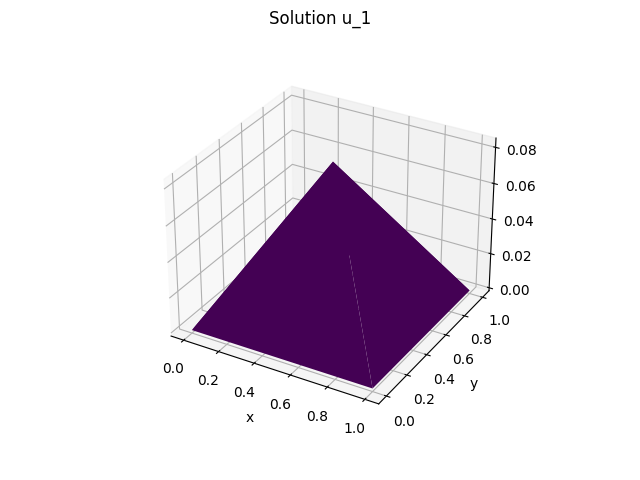

In [14]:
meshOps.plot(u,1)

### Evaluate L2 error

In [15]:
print('num elements:', meshOps.getNumberOfTriangles(), '---',  'L2 error:', '%.2E' % Decimal(meshOps.L2errorOfPoissonProblem(u,param.order)[0]))

num elements: 4 --- L2 error: 3.89E-02


## 1.(b)

In [16]:
meshOps = MeshOperations('mesh/unitSquare2.msh')
param = paramConst

Mesh file: elements have been read


In [18]:
A,f = setEquationSystem(meshOps,param)
A,f = setBoundaryValues(meshOps,A,f,param)
u = meshOps.solve(A,f)

solve completed


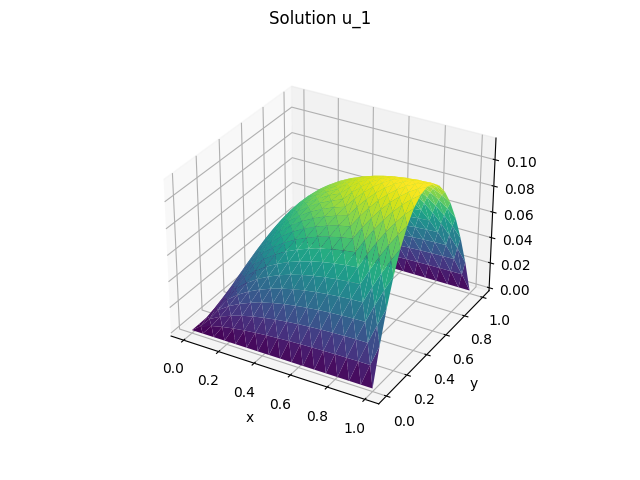

In [19]:
meshOps.plot(u,1)

In [20]:
print('num elements:', meshOps.getNumberOfTriangles(), '---',  'L2 error:', '%.2E' % Decimal(meshOps.L2errorOfPoissonProblem(u,param.order)[0]))

num elements: 1024 --- L2 error: 1.93E-04


## 1.(c)

In [21]:
meshOps = MeshOperations('mesh/unitSquare2.msh')
param = paramSin

Mesh file: elements have been read


In [22]:
A,f = setEquationSystem(meshOps,param)
A,f = setBoundaryValues(meshOps,A,f,param)
u = meshOps.solve(A,f)

solve completed


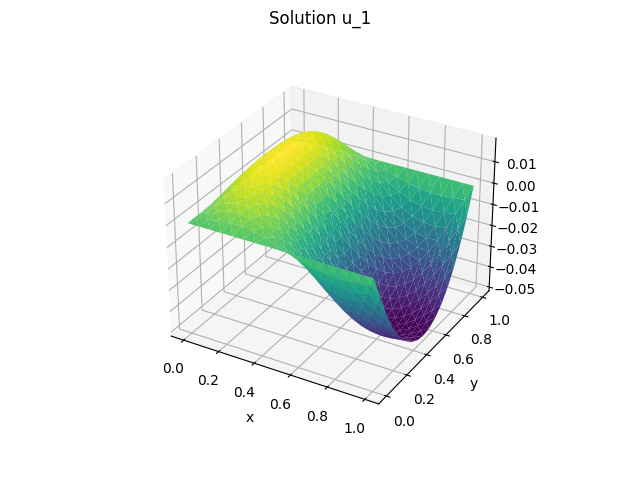

In [23]:
meshOps.plot(u,1)

In [24]:
print('num elements:', meshOps.getNumberOfTriangles(), '---',  'L2 error:', '%.2E' % Decimal(meshOps.L2errorOfPoissonProblem(u,param.order)[0]))

num elements: 1024 --- L2 error: 8.35E-02


# Part 2: Error Evaluation

This is the second half of subtask 2.

In [25]:
def plotError(x, u, title='L2-error ||u-u_h||_{L^2}'):
    # x: number of mesh elements - vector
    # u: error vector
    fig = plt.figure()
    #ax = fig.add_axes([0,0,1,1])
    ax = fig.add_subplot(111)
    ax.loglog(x,u, 'xr--')
    ax.set_xlabel('number of triangles')
    ax.set_ylabel('error')
    ax.set_title(title)
    plt.ylim((10**-4, 10**-2))
    plt.show()

## Evaluate L2 error

Now, we want to investigate the convergence order under grid refinement.
This time, you should implement your own small error evaluation and create a plot of the result. Use the meshes 'mesh64.msh', 'mesh256.msh' and 'mesh1024.msh' with an appropriate set of parameters.
Why must $f(x,y)=1$ to obtain the theoretical convergence rate from the lecture?

In [26]:
# Choose the appropriate parameter set
param = paramConst

# define arrays for plot
numEle = np.zeros(3)
error = np.zeros(3)

# 'mesh64.msh'
meshOps = MeshOperations('mesh/mesh64.msh')
A,f = setEquationSystem(meshOps,param)
A,f = setBoundaryValues(meshOps,A,f,param)
u = meshOps.solve(A,f)
numEle[0] = meshOps.getNumberOfTriangles()
error[0] = meshOps.L2errorOfPoissonProblem(u,param.order)

# 'mesh256.msh'
meshOps = MeshOperations('mesh/mesh256.msh')
A,f = setEquationSystem(meshOps,param)
A,f = setBoundaryValues(meshOps,A,f,param)
u = meshOps.solve(A,f)
numEle[1] = meshOps.getNumberOfTriangles()
error[1] = meshOps.L2errorOfPoissonProblem(u,param.order)

# 'mesh1024.msh'
meshOps = MeshOperations('mesh/mesh1024.msh')
A,f = setEquationSystem(meshOps,param)
A,f = setBoundaryValues(meshOps,A,f,param)
u = meshOps.solve(A,f)
numEle[2] = meshOps.getNumberOfTriangles()
error[2] = meshOps.L2errorOfPoissonProblem(u,param.order)

Mesh file: elements have been read
solve completed
Mesh file: elements have been read
solve completed
Mesh file: elements have been read
solve completed


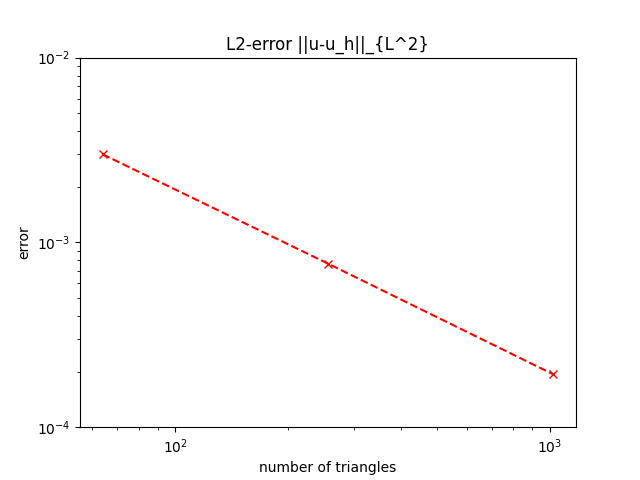

In [27]:
plotError(numEle, error)

# Part 3: Investigate behavior of different parameter sets

If you have successfully implemented the above exercise, we can now study how the parameters effect the solution of our problem

## Generate data

In [28]:
meshOps = MeshOperations('mesh/mesh1024.msh')
paramConstLaplace = [Parameters(laplaceCoeff=1.0), Parameters(laplaceCoeff=10.0), Parameters(laplaceCoeff=100.0)]
paramConstNeumann = [Parameters(neumannCoeff=0.0), Parameters(neumannCoeff=100.0), Parameters(neumannCoeff=-5.0)]
paramConstDirichlet = [Parameters(dirichletValue=0.0), Parameters(dirichletValue=1.0), Parameters(dirichletValue=2.0)]
paramSourceFunction = [Parameters(sourceFunc=(lambda x,y: np.sin(2*np.pi*x))), Parameters(sourceFunc=(lambda x,y: np.sin(4.4*np.pi*x))), Parameters(sourceFunc=(lambda x,y: np.sin(7*np.pi*x)))]

Mesh file: elements have been read


Next, we build and compute our solution for each set of testcases:

## Compute Solutions

In [29]:
paramList = np.array([paramConstLaplace, paramConstNeumann, paramConstDirichlet, paramSourceFunction]).reshape(-1)
solutionList = []

#Compute solutions
for param in paramList:
    A,f = setEquationSystem(meshOps,param)
    A,f = setBoundaryValues(meshOps,A,f,param)
    u = meshOps.solve(A,f)
    solutionList.append(u)

solve completed
solve completed
solve completed
solve completed
solve completed
solve completed
solve completed
solve completed
solve completed
solve completed
solve completed
solve completed


## Reshape Data

In [30]:
solutionList = np.array(solutionList)
#reformat so it can be plotted easily
paramList = paramList.reshape((4,3))
solutionList =  solutionList.reshape((4,3, solutionList.shape[1]))

## Plot Data

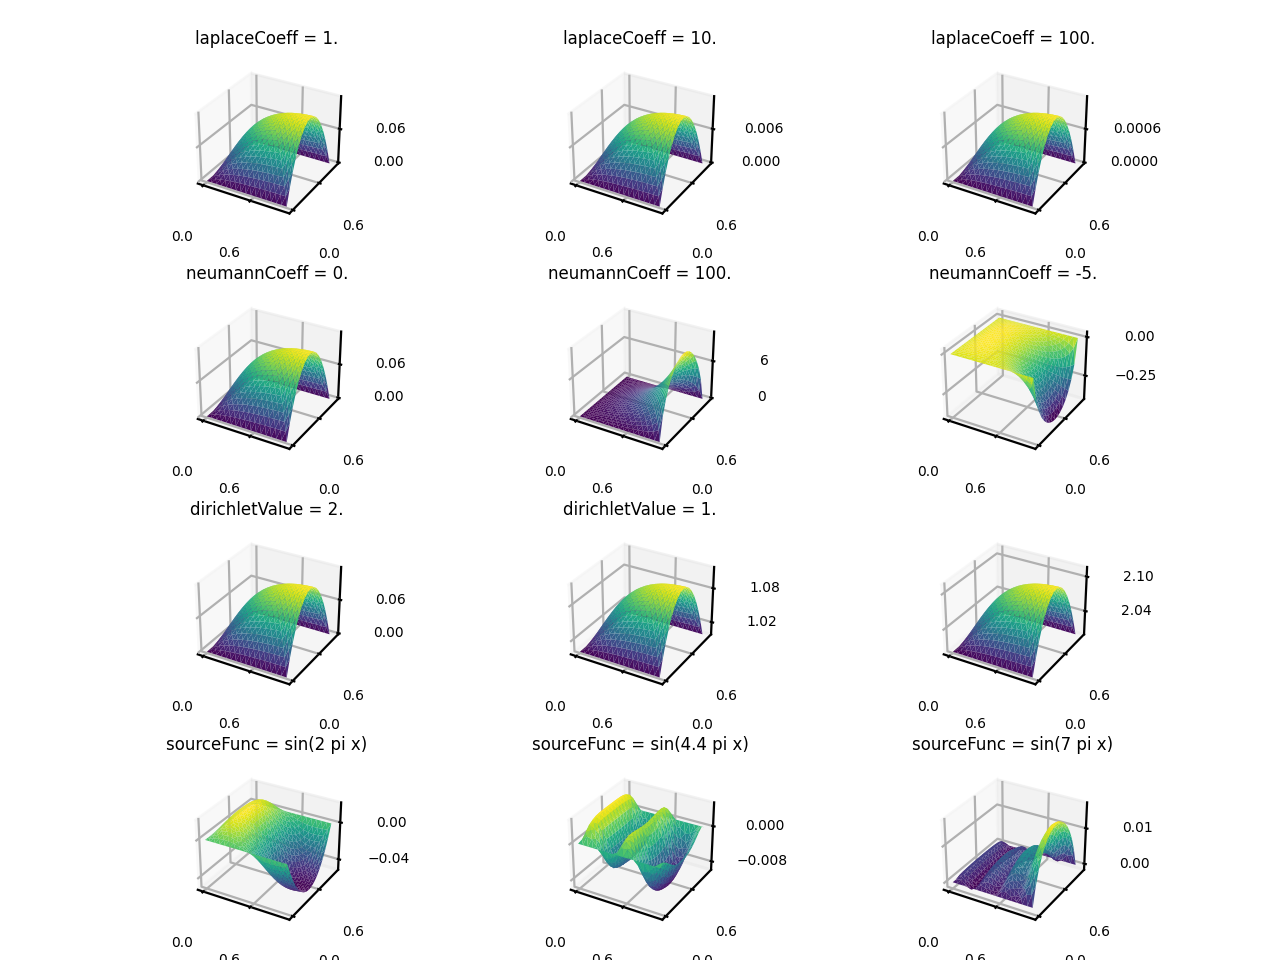

In [31]:
fig = plt.figure()
fig.set_dpi(200)

for i in np.arange(0, 4):
    for j in np.arange(0,3):
        ax = fig.add_subplot(4,3,3*i+j+1, projection='3d')
        x,y,z, tri = meshOps.get_plot_data(solutionList[i,j], 1)
        ax.plot_trisurf(x,y,z,triangles=tri, cmap='viridis')
        ax.tick_params(axis='both', which='major', labelsize=5)
        ax.xaxis.set_major_locator(ticker.MaxNLocator(2)) 
        ax.yaxis.set_major_locator(ticker.MaxNLocator(2)) 
        ax.zaxis.set_major_locator(ticker.MaxNLocator(2)) 
        
fig.axes[0].set_title('laplaceCoeff = 1.', fontsize=6)
fig.axes[1].set_title('laplaceCoeff = 10.', fontsize=6)
fig.axes[2].set_title('laplaceCoeff = 100.', fontsize=6)
fig.axes[3].set_title('neumannCoeff = 0.', fontsize=6)
fig.axes[4].set_title('neumannCoeff = 100.', fontsize=6)
fig.axes[5].set_title('neumannCoeff = -5.', fontsize=6)
fig.axes[6].set_title('dirichletValue = 0.', fontsize=6)
fig.axes[7].set_title('dirichletValue = 1.', fontsize=6)
fig.axes[6].set_title('dirichletValue = 2.', fontsize=6)
fig.axes[9].set_title('sourceFunc = sin(2 pi x)', fontsize=6)
fig.axes[10].set_title('sourceFunc = sin(4.4 pi x)', fontsize=6)
fig.axes[11].set_title('sourceFunc = sin(7 pi x)', fontsize=6)
        
    
plt.tight_layout(h_pad=1.5)
plt.show()

# Part 4: Higher Order Methods

If you want to implement higher order methods, we suggest to start with second order triangular meshes, since a sample mesh already exists.

## Compute 2nd order case

In [32]:
meshOps_2nd = MeshOperations('mesh/unitSquare2ndOrder.msh')
param = paramConst2Order

Mesh file: elements have been read


In [33]:
A,f = setEquationSystem(meshOps_2nd,param)
A,f = setBoundaryValues(meshOps_2nd,A,f,param)
u_2nd = meshOps_2nd.solve(A,f)

solve completed


## Compute 1st order case

In [34]:
meshOps_1st = MeshOperations('mesh/mesh64.msh')
param = paramConst

Mesh file: elements have been read


In [35]:
A,f = setEquationSystem(meshOps_1st,param)
A,f = setBoundaryValues(meshOps_1st,A,f,param)
u_1st = meshOps_1st.solve(A,f)

solve completed


## Plotting

Text(0.5, 0.92, '2nd order')

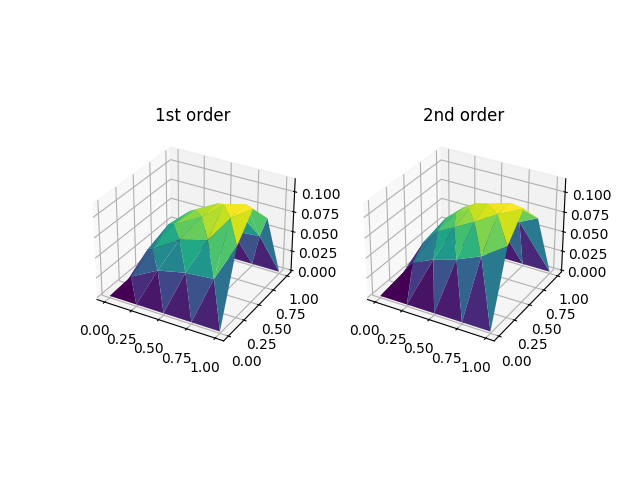

In [36]:
fig = plt.figure()
#fig.set_dpi(200)

ax = fig.add_subplot(1,2,1, projection='3d')
x,y,z, tri = meshOps_1st.get_plot_data(u_1st, 1)
ax.plot_trisurf(x,y,z,triangles=tri, cmap='viridis')
ax = fig.add_subplot(1,2,2, projection='3d')
x,y,z, tri = meshOps_2nd.get_plot_data(u_2nd, 1)
ax.plot_trisurf(x,y,z,triangles=tri, cmap='viridis')
#ax.tick_params(axis='both', which='major', labelsize=5)
#ax.xaxis.set_major_locator(ticker.MaxNLocator(2)) 
#ax.yaxis.set_major_locator(ticker.MaxNLocator(2)) 
#ax.zaxis.set_major_locator(ticker.MaxNLocator(2)) 
        
fig.axes[0].set_title('1st order')
fig.axes[1].set_title('2nd order')


# Part 5: Beyond Triangular Meshes

If you want to go beyond triangular meshes, you will need to carefully adapt the file 'MeshOperations.py'. Only the 
- load_gmsh(...)

function is complete. You also need to generate an appropriate mesh. 
You may want to the following two resources
- http://www.manpagez.com/info/gmsh/gmsh-2.2.6/gmsh_63.php
- https://gmsh.info/doc/texinfo/gmsh.html#MSH-file-format

as well as have a look at the provided triangular meshes.

In [37]:
# TODO for industrious students